In [ ]:
!pip install transformers

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader, Sampler
from collections import defaultdict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
import tensorflow as tf

In [2]:
# 加载数据
data = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
data['language'].unique()

array(['English', 'French', 'Thai', 'Turkish', 'Urdu', 'Russian',
       'Bulgarian', 'German', 'Arabic', 'Chinese', 'Hindi', 'Swahili',
       'Vietnamese', 'Spanish', 'Greek'], dtype=object)

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型
MODEL_NAME = 'joeddav/xlm-roberta-large-xnli'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# 加载合适的分词器
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 设置超参数，控制隐藏层早停的概率
model.config.hidden_dropout_prob = 0.2  # Enable dropout

# 将模型部署到指定设备上，加速后续的训练
model.to(dev)

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

In [4]:
# Calculate class weights for weighted loss
label_counts = data['label'].value_counts().sort_index()
class_weights = torch.tensor(
    [len(data) / (3 * count) for count in label_counts.values],
    dtype=torch.float32
).to(dev)
print("Class weights:", class_weights)

Class weights: tensor([0.9674, 1.0412, 0.9941], device='cuda:0')


In [5]:
# Train-Eval Split with stratification by language and label
data['language'] = data['language'].astype(str)

In [6]:
# 数据类的定义
class NLI_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Create language and label mappings for the sampler
        self.language_indices = defaultdict(list)
        self.label_indices = defaultdict(list)
        
        for idx, row in self.data.iterrows():
            self.language_indices[row['language']].append(idx)
            self.label_indices[row['label']].append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Using tokenizer more effectively with special tokens
        tokens = self.tokenizer(
            row['premise'], 
            row['hypothesis'], 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_length, 
            return_tensors='pt'
        )
        return {key: val.squeeze() for key, val in tokens.items()}, torch.tensor(row['label'])

In [7]:
# 选择每一个批次的样本（返回的是样本的索引，DataLoader通过索引来加载数据）
# 继承自torch.utils.daat.Sample
class FixedLanguageSampler(Sampler):
    def __init__(self, dataset, batch_size=32, langs_per_batch=5):
        self.dataset = dataset
        self.batch_size = batch_size
        self.langs_per_batch = langs_per_batch
        self.languages = list(dataset.language_indices.keys())
        self.num_batches = len(dataset) // batch_size

    def __iter__(self):
        for _ in range(self.num_batches):
            langs = np.random.choice(self.languages, self.langs_per_batch, replace=False)
            batch = []
            samples_per_lang = self.batch_size // len(langs)
            remainder = self.batch_size % len(langs)
            
            for i, lang in enumerate(langs):
                n = samples_per_lang + (1 if i < remainder else 0)
                indices = self.dataset.language_indices[lang]
                if len(indices) < n:
                    selected = np.random.choice(indices, n, replace=True)
                else:
                    selected = np.random.choice(indices, n, replace=False)
                batch.extend(selected)
            yield batch

    def __len__(self):
        return self.num_batches  # Correct: number of batches

In [8]:
def stratified_split(data, low_resource_threshold=500, low_resource_ratio=0.9, high_resource_ratio=0.8):
    """
    分层抽样函数
    特性：
    1. 双重分层（语言 + 标签）
    2. 动态余数分配
    3. 极小标签保护（每个标签至少1个训练样本）
    4. 随机打乱数据
    5. 精确样本数控制
    """
    train_data, eval_data = [], []

    # 按语言分组
    for lang, lang_group in data.groupby('language'):
        # 随机打乱整个语言组
        lang_group = lang_group.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # 确定划分比例
        lang_total = len(lang_group)
        ratio = low_resource_ratio if lang_total < low_resource_threshold else high_resource_ratio
        target_train_size = int(lang_total * ratio)
        
        # 按标签分层
        lang_train, lang_eval = [], []
        label_groups = []
        label_counts = []
        
        # 第一阶段：收集所有标签组并打乱
        for label, label_group in lang_group.groupby('label'):
            shuffled_group = label_group.sample(frac=1, random_state=42).reset_index(drop=True)
            label_groups.append(shuffled_group)
            label_counts.append(len(shuffled_group))
        
        # 第二阶段：计算初始分配（使用四舍五入）
        proportions = np.array(label_counts) / lang_total
        allocations = np.round(proportions * target_train_size).astype(int)
        
        # 第三阶段：动态调整余数
        current_total = allocations.sum()
        remainder = target_train_size - current_total
        
        # 按标签样本数降序分配余数
        if remainder != 0:
            sorted_indices = np.argsort(label_counts)[::-1]
            for i in sorted_indices:
                if remainder == 0:
                    break
                adjust = 1 if remainder > 0 else -1
                if allocations[i] + adjust >= 1 and allocations[i] + adjust <= len(label_groups[i]):
                    allocations[i] += adjust
                    remainder -= adjust
        
        # 第四阶段：应用分配并确保最小样本
        for i, (label_group, alloc) in enumerate(zip(label_groups, allocations)):
            # 确保至少1个样本且不超过实际数量
            final_alloc = max(1, min(alloc, len(label_group)-1))  # 至少留1个给测试集
            lang_train.append(label_group.iloc[:final_alloc])
            lang_eval.append(label_group.iloc[final_alloc:])
        
        # 合并当前语言数据
        train_data.append(pd.concat(lang_train, ignore_index=True))
        eval_data.append(pd.concat(lang_eval, ignore_index=True))
    
    # 合并所有语言数据并打乱
    train_data = pd.concat(train_data).reset_index(drop=True)
    eval_data = pd.concat(eval_data).reset_index(drop=True)
    
    return train_data, eval_data

# 构建数据集
train_data, eval_data = stratified_split(data)

In [9]:
# 验证划分结果
print(f"Total Train: {len(train_data)}, Eval: {len(eval_data)}")
print("Language Distribution:")
print(train_data['language'].value_counts() / len(train_data))
print(eval_data['language'].value_counts() / len(eval_data))

Total Train: 10212, Eval: 1908
Language Distribution:
language
English       0.538190
Chinese       0.036134
Arabic        0.035253
French        0.034371
Swahili       0.033882
Urdu          0.033490
Vietnamese    0.033392
Russian       0.033098
Hindi         0.032902
Greek         0.032707
Thai          0.032609
Spanish       0.032217
German        0.030846
Turkish       0.030846
Bulgarian     0.030063
Name: count, dtype: float64
language
English       0.720126
Chinese       0.022013
Arabic        0.021488
French        0.020440
Swahili       0.020440
Urdu          0.020440
Greek         0.019916
Vietnamese    0.019916
Thai          0.019916
Russian       0.019916
Hindi         0.019916
Spanish       0.019392
German        0.018868
Turkish       0.018868
Bulgarian     0.018344
Name: count, dtype: float64


In [10]:
# Create Datasets
train_dataset = NLI_Dataset(train_data, tokenizer, max_length=150)  # Increased max length
eval_dataset = NLI_Dataset(eval_data, tokenizer, max_length=150)

# Create DataLoaders with balanced sampling
train_sampler = FixedLanguageSampler(train_dataset, batch_size=24, langs_per_batch=5)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [11]:
# 选用交叉熵损失函数作为损失函数
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 使用AdamW优化器，处理权重衰减问题
optimizer = AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)  # Adjusted learning rate and weight decay

# 总的训练周期
num_epochs = 5
total_steps = len(train_loader) * num_epochs

# 预热
num_warmup_steps = int(total_steps * 0.1)

# 线性学习率调度器
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=total_steps
)

# 最佳准确度
best_acc = 0.0

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# 切换到训练模式
model.train()

#进行训练
for epoch in range(num_epochs):
    total_loss, correct, total = 0, 0, 0
    
    # 用于追踪每种语言的准确度
    lang_correct = defaultdict(int)
    lang_total = defaultdict(int)
    
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = batch
        inputs = {key: val.to(dev) for key, val in inputs.items()}
        labels = labels.to(dev)
        
        # Get batch language info for logging
        batch_indices = list(range(batch_idx * train_loader.batch_sampler.batch_size, 
                           min((batch_idx + 1) * train_loader.batch_sampler.batch_size, len(train_dataset))))
        batch_languages = [train_data.iloc[idx]['language'] for idx in batch_indices if idx < len(train_data)]
        
        outputs = model(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        # Log every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")
    
    # Evaluate on each epoch
    model.eval()
    eval_preds, eval_true = [], []
    eval_correct, eval_total = 0, 0
    eval_lang_correct = defaultdict(int)
    eval_lang_total = defaultdict(int)
    
    with torch.no_grad():
        for batch in eval_loader:
            inputs, labels = batch
            inputs = {key: val.to(dev) for key, val in inputs.items()}
            labels = labels.to(dev)
            outputs = model(**inputs).logits
            preds = outputs.argmax(dim=1)
            
            eval_preds.extend(preds.cpu().numpy())
            eval_true.extend(labels.cpu().numpy())
            
            eval_correct += (preds == labels).sum().item()
            eval_total += labels.size(0)
    
    eval_acc = eval_correct / eval_total
    print(f"Evaluation Accuracy: {eval_acc:.4f}")
    
    # Save Best Model
    if eval_acc > best_acc:
        best_acc = eval_acc
        model.save_pretrained("/kaggle/working/best_xlmr")
        tokenizer.save_pretrained("/kaggle/working/best_xlmr")
        print("Best model saved!")
    
    # Switch back to training mode
    model.train()

Epoch 1, Batch 0, Loss: 5.4761
Epoch 1, Batch 100, Loss: 3.9152
Epoch 1, Batch 200, Loss: 0.9767
Epoch 1, Batch 300, Loss: 0.6929
Epoch 1, Batch 400, Loss: 0.5015
Epoch 1: Loss = 1.9710, Accuracy = 0.4680
Evaluation Accuracy: 0.8281
Best model saved!
Epoch 2, Batch 0, Loss: 0.3411
Epoch 2, Batch 100, Loss: 0.2612
Epoch 2, Batch 200, Loss: 0.1371
Epoch 2, Batch 300, Loss: 0.0408
Epoch 2, Batch 400, Loss: 0.3736
Epoch 2: Loss = 0.1711, Accuracy = 0.9539
Evaluation Accuracy: 0.9046
Best model saved!
Epoch 3, Batch 0, Loss: 0.1331
Epoch 3, Batch 100, Loss: 0.1355
Epoch 3, Batch 200, Loss: 0.0048
Epoch 3, Batch 300, Loss: 0.1982
Epoch 3, Batch 400, Loss: 0.0024
Epoch 3: Loss = 0.0826, Accuracy = 0.9784
Evaluation Accuracy: 0.9119
Best model saved!
Epoch 4, Batch 0, Loss: 0.0056
Epoch 4, Batch 100, Loss: 0.0036
Epoch 4, Batch 200, Loss: 0.0037
Epoch 4, Batch 300, Loss: 0.0049
Epoch 4, Batch 400, Loss: 0.0598
Epoch 4: Loss = 0.0768, Accuracy = 0.9803
Evaluation Accuracy: 0.9135
Best model sav

Final Classification Report:
               precision    recall  f1-score   support

contradiction       0.91      0.93      0.92       663
      neutral       0.89      0.89      0.89       607
   entailment       0.94      0.92      0.93       638

     accuracy                           0.92      1908
    macro avg       0.92      0.91      0.92      1908
 weighted avg       0.92      0.92      0.92      1908



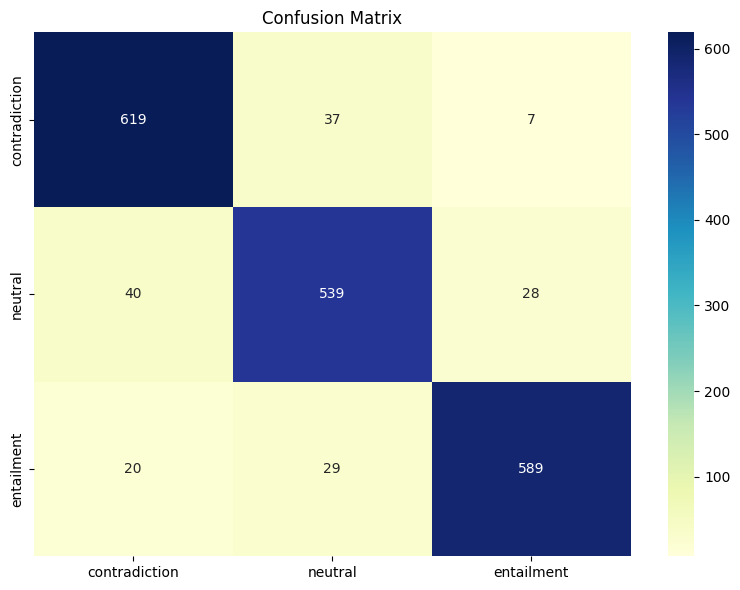

In [13]:
# Load Best Model for Final Evaluation
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/working/best_xlmr")
model.to(dev)
model.eval()

# Final Evaluation
preds, true_labels = [], []
with torch.no_grad():
    for batch in eval_loader:
        inputs, labels = batch
        inputs = {key: val.to(dev) for key, val in inputs.items()}
        labels = labels.to(dev)
        outputs = model(**inputs).logits
        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Final Classification Report:")
print(classification_report(true_labels, preds, target_names=['contradiction','neutral','entailment']))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="YlGnBu", annot=True, fmt='g', 
           xticklabels=['contradiction','neutral','entailment'], 
           yticklabels=['contradiction','neutral','entailment'])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [14]:
# Load test dataset and make predictions
test_data = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')
print(f"Loaded test dataset with {len(test_data)} samples")

# 创建测试数据集类
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=150):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.ids = dataframe['id'].values
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tokens = self.tokenizer(
            row['premise'], 
            row['hypothesis'], 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_length, 
            return_tensors='pt'
        )
        return {key: val.squeeze() for key, val in tokens.items()}, self.ids[idx]

# 创建测试数据集和数据加载器
test_dataset = TestDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 进行预测
predictions = []
prediction_ids = []
with torch.no_grad():
    for batch in test_loader:
        inputs, ids = batch
        inputs = {key: val.to(dev) for key, val in inputs.items()}
        
        # 进行预测
        outputs = model(**inputs).logits
        batch_preds = outputs.argmax(dim=1).cpu().numpy()
        
        predictions.extend(batch_preds)
        prediction_ids.extend(ids)

# 创建预测结果数据框
results_df = pd.DataFrame({
    'id': prediction_ids,
    'prediction': predictions
})

# 保存预测结果到CSV
results_df[['id', 'prediction']].to_csv('/kaggle/working/submission.csv', index=False)
print("Predictions saved to 'submission.csv'")

Loaded test dataset with 5195 samples
Predictions saved to 'submission.csv'
